# Neural Architecture Search without Training (NASWOT) on CI10 (Tensorflow Backend)
In this notebook we will demonstrate how to search for high performing networks by evaluating measures at initialization which are indicative of their trained performance as described in [Neural Architecture Search without Training](https://arxiv.org/pdf/2006.04647.pdf). Cost of hand designing neural networks is very high. To automate this `Neural Architecture Search (NAS)` methods were devised but they are very slow and expensive. `NASWOT` allows `NAS` to be performed without training. 

NASWOT aims at estimating how well a network can distinguish the input images at initialization. The idea is that the network able to distinguish input images better at initialization has more expressivity and hence ability to have better performance post training. For a neural network with rectified linear units (`ReLU`s), we can identify when the unit is active (value greater than zero) or inactive (negative value) and use it to create a binary indicator, thereby defining the network by a linear operator. We can use this to generate a binary code (active as `1` and inactive as `0`) at each `ReLU` layer. It’s more difficult for the network to distinguish the inputs with similar binary codes as they lie in the same linear region of the network. Conversely, it’s easier when the binary codes are significantly different. So, NASWOT uses `Hamming distance` between two binary codes to estimate how dissimilar two inputs are.

In the algorithm demonstrated below, we'll score the networks at initialization and observe the correlation between these scores and their final trained performance. We'll use `NAS-Bench-201` which is search space consisting of architectures and information about their performance. 

In [1]:
import os
import tempfile
import wget
import numpy as np
import pandas as pd
from scipy import stats

import tensorflow as tf
from tensorflow.keras import Model, layers

import fastestimator as fe
from fastestimator.dataset.data import cifar10
from fastestimator.op.numpyop.univariate import Normalize
from fastestimator.search import GridSearch
from fastestimator.util import to_number
from fastestimator.util.wget_util import bar_custom, callback_progress

Let's define our training parameters. We have extracted the information required for our showcase from `NAS-Bench-201` into a csv file for ease of use, which we will be downloading here. We will be randomly selecting 50 architectures for demonstrative purposes.

In [2]:
# Parameters
batch_size=128 
num_archs=50
save_dir = tempfile.mkdtemp()
download_link = "https://github.com/fastestimator-util/fastestimator-misc/raw/master/resource/nasbench201_info.csv"

## Building Components

### Downloading the data
Let's download the `NAS-Bench-201` information. We will randomly select few architectures to evaluate.

In [3]:
wget.callback_progress = callback_progress

wget.download(download_link, save_dir, bar=bar_custom)
config_info = pd.read_csv(os.path.join(save_dir, "nasbench201_info.csv"))

# Id's of architectures selected randomly
uid_list = np.random.choice(15625, size=num_archs, replace=False) 

100% [......................................................]    1.99 / 1.99 MB


### Step 1: Create `Pipeline`
We require only one batch of training data for evaluating the networks. Also, we need to ensure same data input to all the networks. So, we'll use `get_results` method of pipeline to retrieve a batch of data.

In [4]:
train_data, _ = cifar10.load_data()
pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
    ])

batch_data = pipeline.get_results()

 FastEstimator-Warn: Consider using the ciFAIR10 dataset instead.


### Step 2: Create `Network`
We need to dynamically create a network from the architecture definition string available in `NAS-Bench-201`. Networks belonging to NAS-Bench-201 have the following structure:
<p align="center">
  <img src="https://github.com/fastestimator-util/fastestimator-misc/blob/master/resource/pictures/apphub/naswot/nasbench201_architecture.PNG?raw=true">
</p>

*Image Credit: [NAS-Bench-201 Paper](https://arxiv.org/pdf/2001.00326.pdf)*
* Cells are directed acyclic graphs consisting of nodes and edges.
* Each cell has 4 nodes.
* Each edge can have one of the 5 predefined edge operations. 

In [5]:
# Define the operation set
OPS = {
    'none':
    lambda inputs,
    n_filters,
    stride: _zero(inputs, n_filters),
    'avg_pool_3x3':
    lambda inputs,
    n_filters,
    stride: _pooling(inputs, n_filters, stride),
    'nor_conv_3x3':
    lambda inputs,
    n_filters,
    stride: _relu_conv_bn_block(inputs, n_filters, (3, 3), stride, "same", 1),
    'nor_conv_1x1':
    lambda inputs,
    n_filters,
    stride: _relu_conv_bn_block(inputs, n_filters, (1, 1), stride, "valid", 1),
    'skip_connect':
    lambda inputs,
    n_filters,
    stride: _identity(inputs)
    if stride == 1 and inputs.shape[-1] == n_filters else _factorize_reduce(inputs, n_filters, stride),
}


def _resnet_basic_block(inputs, n_filters, stride):
    assert stride == 1 or stride == 2, 'invalid stride {:}'.format(stride)
    x = _relu_conv_bn_block(inputs, n_filters, kernel_size=3, stride=stride, padding="same", dilation=1)
    x = _relu_conv_bn_block(x, n_filters, kernel_size=3, stride=1, padding="same", dilation=1)

    if stride == 2:
        residual = layers.AveragePooling2D(pool_size=2, strides=stride, padding="valid")(inputs)
        residual = layers.Conv2D(n_filters, 1, 1, padding="valid", use_bias=False)(residual)
    elif inputs.shape[-1] != n_filters:
        residual = _relu_conv_bn_block(inputs, kernel_size=1, stride=1, padding="valid", dilation=1)
    else:
        residual = inputs

    return residual + x


def _relu_conv_bn_block(inputs, n_filters, kernel_size, stride, padding, dilation):
    x = layers.ReLU()(inputs)
    x = layers.Conv2D(n_filters, kernel_size, stride, padding=padding, dilation_rate=dilation, use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    return x


def _pooling(inputs, n_filters, stride):
    if inputs.shape[-1] != n_filters:
        inputs = _relu_conv_bn_block(inputs, n_filters, kernel_size=1, stride=1, padding="valid", dilation=1)

    x = layers.AveragePooling2D(pool_size=3, strides=stride, padding="same")(inputs)
    return x


def _identity(inputs):
    return inputs


def _zero(inputs, n_filters):
    inp_shape = inputs.shape

    if inp_shape[-1] == n_filters:
        return 0. * inputs
    else:
        inp_shape[-1] = n_filters
        return tf.zeros(inp_shape, inputs.dtype)


def _factorize_reduce(inputs, n_filters, stride):
    if stride == 2:
        filters_list = [n_filters // 2, n_filters - n_filters // 2]
        x = layers.ReLU()(inputs)
        y = tf.pad(inputs, [0, 0, 1, 1], mode="CONSTANT")
        x = layers.Conv2D(filters_list[0], kernel_size=1, stride=stride, padding="valid", use_bias=False)(x)
        y = layers.Conv2D(filters_list[1], kernel_size=1, stride=stride, padding="valid",
                          use_bias=False)(y[:, 1:, 1:, :])
        out = tf.cat([x, y], dim=1)
    elif stride == 1:
        out = layers.Conv2D(n_filters, kernel_size=1, stride=stride, padding="valid", use_bias=False)(inputs)
    else:
        raise ValueError('Invalid stride : {:}'.format(stride))

    out = layers.BatchNormalization(momentum=0.9)(out)
    return out


def str2structure(xstr):
    assert isinstance(xstr, str), 'must take string (not {:}) as input'.format(type(xstr))
    nodestrs = xstr.split('+')
    genotypes = []
    for node_str in nodestrs:
        inputs = list(filter(lambda x: x != '', node_str.split('|')))
        for xinput in inputs:
            assert len(xinput.split('~')) == 2, 'invalid input length : {:}'.format(xinput)
        inputs = (xi.split('~') for xi in inputs)
        input_infos = tuple((op, int(IDX)) for (op, IDX) in inputs)
        genotypes.append(input_infos)
    return genotypes


def _infer_cell(inputs, genotype, n_filters, stride):
    x_in = [inputs]

    for i in range(len(genotype)):
        node_info = genotype[i]
        if len(node_info) == 1:
            op_name, op_in = node_info[0]
            x = OPS[op_name](x_in[op_in], n_filters, stride) if op_in == 0 else OPS[op_name](x_in[op_in], n_filters, 1)
        else:
            x = layers.Add()([
                OPS[op_name](x_in[op_in], n_filters, stride) if op_in == 0 else OPS[op_name](x_in[op_in], n_filters, 1)
                for (op_name, op_in) in node_info
            ])
        x_in.append(x)

    return x


def nasbench_network(input_shape, genotype, C=16, N=5, num_classes=10):
    layer_channels = [C] * N + [C * 2] + [C * 2] * N + [C * 4] + [C * 4] * N
    layer_reductions = [False] * N + [True] + [False] * N + [True] + [False] * N

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(C, kernel_size=3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)

    for (C_curr, reduction) in zip(layer_channels, layer_reductions):
        if reduction:
            x = _resnet_basic_block(x, n_filters=C_curr, stride=2)
        else:
            x = _infer_cell(x, genotype=genotype, n_filters=C_curr, stride=1)

    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, x)
    return model

### Step 3: Define scoring function
Now that we have the network and input data defined, we'll be using `FE`'s `GridSearch` to search for the best network according to the score generated through `NASWOT` method. Let's define the score function to score each network. 
The score is generated by calculate the log of determinant of the kernel matrix created using hamming distance between the binary codes for a batch of data. For more deatils, please refer to the [original paper](https://arxiv.org/pdf/2006.04647.pdf).
Note that in the score function, one of the arguments must be `search_idx`. This is to help user differentiate multiple search runs

In [6]:
def score_fn(search_idx, uid, batch_data, config_info):
    config = config_info.loc[uid, :]
    nasbench201_model = nasbench_network((32, 32, 3),
                                     str2structure(config["architecture"]),
                                     config["C"],
                                     config["N"],
                                     10)
    feature_list = [layer.output for layer in nasbench201_model.layers if "re_lu" in layer.name]
    model = fe.build(model_fn=lambda: Model(nasbench201_model.input, feature_list), optimizer_fn=None)
    
    # Only a single forward pass through the network is required
    relu_result = fe.backend.feed_forward(model, batch_data["x"], training=False)
    matrix = np.zeros((relu_result[0].shape[0], relu_result[0].shape[0]))
    for sample in relu_result:
        sample = to_number(sample)
        sample = sample.reshape((sample.shape[0], -1))
        x = (sample > 0.).astype(float)
        x_t = np.transpose(x)
        mat = x @ x_t
        mat2 = (1. - x) @ (1. - x_t)
        matrix = matrix + mat + mat2

    _, score = np.linalg.slogdet(matrix)
    return score

### Step 4: Apply `GridSearch`
Now we can search for the best network using `GridSearch` API. We call `fit` method to apply grid search.

In [7]:
search = GridSearch(
    eval_fn=lambda search_idx,
    uid: score_fn(search_idx, uid, batch_data=batch_data, config_info=config_info),
    params={"uid": uid_list},
    best_mode="max")
    
search.fit()

FastEstimator-Search: Evaluated {'uid': 1100, 'search_idx': 1}, score: 1556.5129935894533
FastEstimator-Search: Evaluated {'uid': 4003, 'search_idx': 2}, score: 1568.7514623128604
FastEstimator-Search: Evaluated {'uid': 2950, 'search_idx': 3}, score: 1481.2117086672417
FastEstimator-Search: Evaluated {'uid': 14647, 'search_idx': 4}, score: 1633.212016094945
FastEstimator-Search: Evaluated {'uid': 11962, 'search_idx': 5}, score: 1380.482954956914
FastEstimator-Search: Evaluated {'uid': 5807, 'search_idx': 6}, score: 1166.5637417966832
FastEstimator-Search: Evaluated {'uid': 15514, 'search_idx': 7}, score: 1380.4204749164292
FastEstimator-Search: Evaluated {'uid': 6745, 'search_idx': 8}, score: 1592.3035197306224
FastEstimator-Search: Evaluated {'uid': 3991, 'search_idx': 9}, score: 1482.438068951114
FastEstimator-Search: Evaluated {'uid': 13236, 'search_idx': 10}, score: 1512.2366164324421
FastEstimator-Search: Evaluated {'uid': 916, 'search_idx': 11}, score: 1575.5872402983732
FastEsti

We can the get the best results using the `get_best_results` and all the results through `get_search_results` methods. Let's assemble the scores and the test accuracies of the trained networks (available through `NAS-Bench-201`) for checking how well the scores and final performance correlate.

### Results

In [8]:
best_results = search.get_best_results()
score_list = [result['result']['value'] for result in search.get_search_summary()]
acc_list = [config_info.loc[i, :]["accuracy"] for i in uid_list]

tau, _ = stats.kendalltau(acc_list, score_list)
print("Kendall's Tau correlation coefficient: ", tau)

Kendall's Tau correlation coefficient:  0.6533279434000336


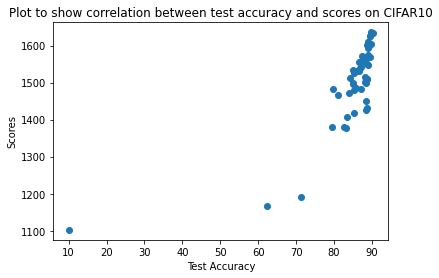

In [9]:
import matplotlib.pyplot as plt

plt.scatter(acc_list, score_list)
plt.title("Plot to show correlation between test accuracy and scores on CIFAR10")
plt.xlabel("Test Accuracy")
plt.ylabel("Scores")
plt.show()

This indicates that there is a noticeable correlation between score for an untrained network and the final accuracy when trained. Let's also check how the network with the best score performed on the actual task as compared to all the other candidates. 

In [10]:
print("Maximum accuracy among all the networks tested: ", np.max(acc_list))
print("Params for best network: {}, best score: {} and corresponding accuracy: {}".format(
    best_results['param'],
    best_results['result']['value'],
    config_info.loc[best_results['param']["uid"], :]["accuracy"]))
print(
    "The best network is the top - {} network among the selected networks, based on trained performance (accuracy)".
    format(len(acc_list) - list(np.sort(acc_list)).index(config_info.loc[best_results['param']["uid"], :]["accuracy"])))


Maximum accuracy among all the networks tested:  90.29
Params for best network: {'uid': 4641, 'search_idx': 27}, best score: 1635.8802666171473 and corresponding accuracy: 89.815
The highest scoring network is the top - 3 network among the selected networks, based on trained performance (accuracy)
